In [1]:
import numpy as np
import mglearn
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import matplotlib.pyplot as plt

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Generating dataset
2차원 상에서 선형 분류가 어려운 dataset 생성

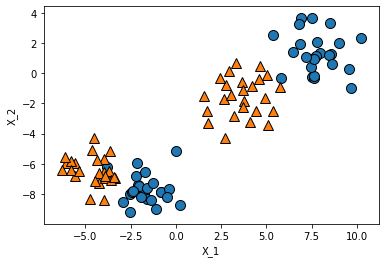

In [2]:
X, y = make_blobs(centers=4, random_state=25)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.savefig('1.png')
plt.show()

# SVC
![SVM](svc.png)

* 데이터를 구분하는 직선(혹은 hyperplane)을 찾는 것
* 직선으로부터 support vector까지의 거리가 가장 큰 것이 합리적. 두 개의 그룹 $y=\{-1, 1\}$에 대해 직선 $f(X)=\beta_0 + \beta^T X = 0$를 찾아야 한다. 어떻게?

    임의의 관측치 $X_i$에 대하여 $y_i = 1$이면 $\beta_0 + \beta^T X_i \geq 1$ 이어야 하고 $y_i = -1$이면 $\beta_0 + \beta^T X_i \leq -1$ 이어야 한다.
    
    다시 말해, 상위 support vector($X_+$)는 $\beta_0 + \beta^T X = 1$를 만족해야 하고, 하위 support vector($X_-$)는 $\beta_0 + \beta^T X = -1$를 만족해야 한다. 
    
    따라서 두 직선 사이의 거리는 $\beta^T(X_+ - X_-) = 2$이다. 표준화 과정을 거치면 $\frac{\beta^T}{|\beta|}(X_+ - X_-) = \frac{2}{|\beta|}$를 얻고, 우리는 두 직선 사이의 거리를 최대화 해야하므로 $|\beta|$를 최소화 해야한다.
    
    즉, $y_i(\beta_0 + \beta^T x_i) \geq 1$인 조건 하에서 $|\beta|$를 최소화하는 문제로 바뀐다. 하지만 실제 데이터에서는 완벽하게 분류되는 데이터는 없으므로 완화변수(Slack variable, $\xi_i$)를 도입할 필요가 있다.
    
    최종적으로 $y_i(\beta_0 + \beta^T x_i) \geq 1-\xi_i$인 조건 하에서 $|\beta| + C\sum{\xi_i}$를 최소화하는 것이 된다.
    
![slack variable](slack.png)

* Hyperparameter $C$ : 크면 밴드의 넓이가 좁아지며 overfitting 발생 가능. 작으면 밴드의 넓이가 넓어지며 bias 발생 가능.

## Classification with LinearSVC(2D)
성능이 영 좋지 않다.

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


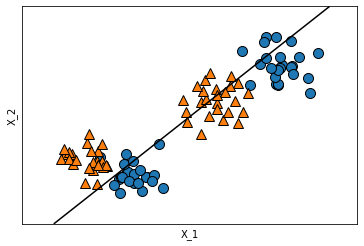

In [3]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.savefig('2.png')
plt.show()

# Kernel SVC
![kernel SVM](ksvc.png)
선형분류가 어려운 경우, 기존의 변수를 사용해 새로운 변수를 추가하여 차원을 증가시킨 후 선형평면을 구하면 된다. 하지만 선형분류가 가능할 때까지 변수를 생성하게 되면 차원이 무한히 증가할 수도 있고 또한 변수를 생성하는 $\phi(\cdot)$를 찾기는 만만치가 않으며 계산량이 많다. 그런데 잘 생각해보면 우리가 최종적으로 사용하는 값은 $\phi(x_i)^T\phi(x_j)$의 **값**이다. 다시 말해 $\phi(\cdot)$을 알지 못하더라도 저 값을 찾아주는 **Kernel**을 잘 디자인하면 되는 것이다. 이를 Kernel Trick이라고 하며 다음과 같은 Kernel이 있다. 
1. linear kernel : $K(x_i, x_j) = x_i^Tx_j$
2. polynomial kernel : $K(x_i, x_j) = (x_i^Tx_j + c)^d, \text{ where } c>0$. $d$차원으로 차원 증가
3. sigmoid kernel : $K(x_i, x_j) = tanh[a(x_i^Tx_j)+b], \text{ where } a,b \geq 0$
4. gaussian kernel : $K(x_i, x_j) = exp[-\frac{|x_i-x_j|^2}{2\sigma^2}] \text{ where } \sigma \neq 0$

위의 Kernel을 이용하여 차원을 증가시킨 후, 선형평면을 찾으면 되겠다.

## Adding 3rd variable
두번째 변수를 제곱하여 세번째 변수 추가(2차원 -> 3차원). 이건 단순히 변수를 추가하여 분류한 것이고 kernel trick을 사용하진 않았다.

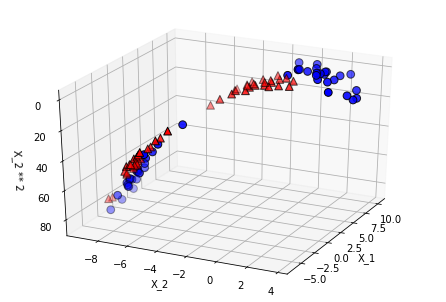

In [4]:
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프 plotting
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0인 포인트를 먼저 그리고 그다음 y == 1인 포인트를 그린다.
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("X_1")
ax.set_ylabel("X_2")
ax.set_zlabel("X_2 ** 2")
plt.savefig('3.png')
plt.show()

## Classification with LinearSVC(3D)
2차원 분류는 직선이 구해지지만 3차원 분류는 평면이 구해진다. 그 모습은 다음과 같다.

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


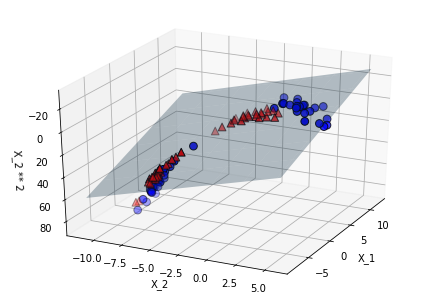

In [5]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("X_1")
ax.set_ylabel("X_2")
ax.set_zlabel("X_2 ** 2")
plt.savefig('4.png')
plt.show()

2차원으로 다시 projection한 결과이다. 앞선 경우보다는 개선되었지만 여전히 부족하다.

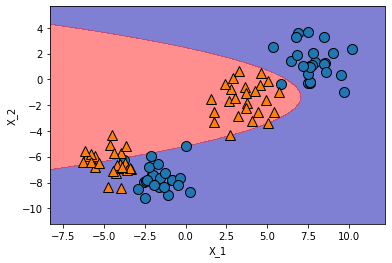

In [6]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.savefig('5.png')
plt.show()

## Classification with SVC using kernel
앞선 결과보다 훨씬 정확하다. 굵은 테두리의 element는 support vector.  `kernel='rbf'` 사용

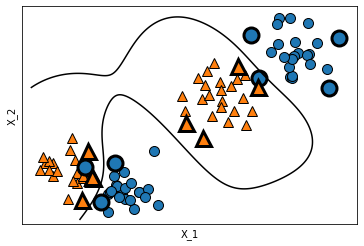

In [7]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다.
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.savefig('6.png')
plt.show()

`C`와 `gamma`를 변경하며 분류한 결과.

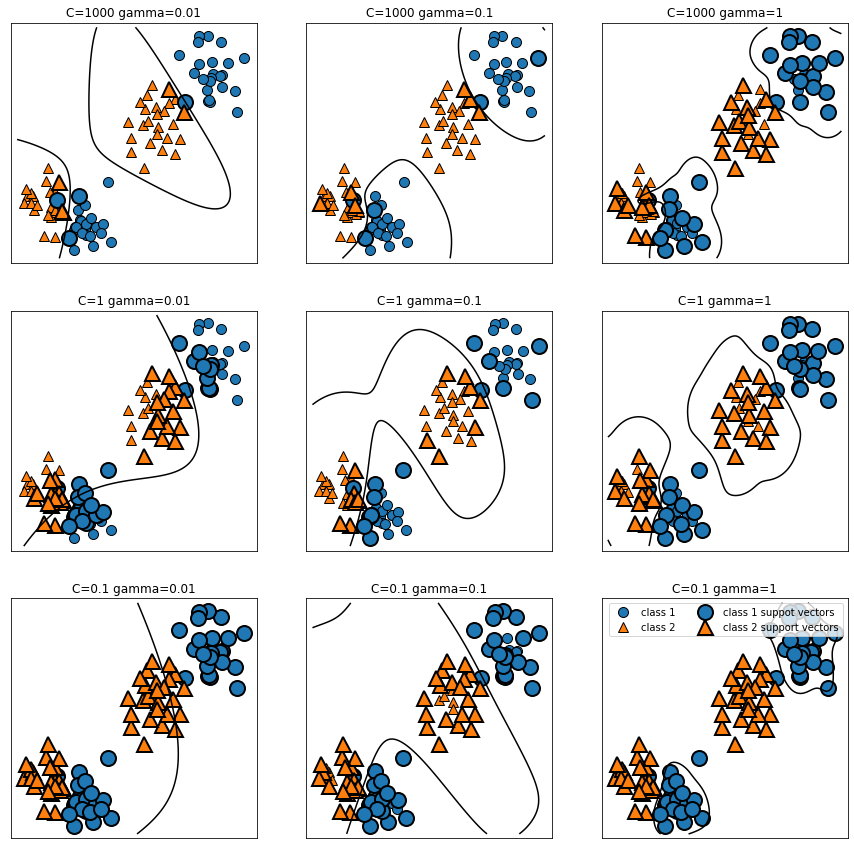

In [8]:
plt.figure(figsize=(15,15))

for sp, C in zip(range(0,10,3),[3,0,-1]):
    for s, gamma in zip(range(1,4),range(-2,1)):
        plt.subplot(330+sp+s)
        svm = SVC(kernel='rbf', C=10**C, gamma=10**gamma).fit(X, y)
        mglearn.plots.plot_2d_separator(svm, X, eps=.5)
        mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
        sv = svm.support_vectors_
        sv_labels = svm.dual_coef_.ravel() > 0
        mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=2)
        plt.title("C={} gamma={}".format(10**C, 10**gamma))
        
plt.legend(["class 1", "class 2", "class 1 suppot vectors", "class 2 support vectors"],
                  ncol=2, loc="upper right")
plt.savefig('7.png')
plt.show()